In [1]:
import pandas as pd
import yaml
import random
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import LayerNormalization,BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout
from tensorflow.keras.models import model_from_yaml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

np.set_printoptions(suppress=True)

In [2]:
def readFile(filePath):
    lemma_result = pd.read_csv(filePath)
    print(lemma_result.shape)
    return lemma_result

In [3]:
def checkLength(max_feat, file):
    leng = 0
    sentence = []
    allData = file['cleaned_review']

    max_fatures = max_feat
    tokenizer = Tokenizer(num_words=max_fatures, split=' ') 
    tokenizer.fit_on_texts(allData.values)
    X1 = tokenizer.texts_to_sequences(allData.values)
    
    for i in X1:
        if len(i)>leng:
            leng = len(i)
            sentence = i
    print(leng)
    print(sentence)
    return leng

In [4]:
def beforeCreateModel(max_feat,dataset,max_length):
    max_fatures = max_feat #จำนวนคำที่ใช้ใน model
    tokenizer = Tokenizer(num_words=max_fatures, split=' ') 
    tokenizer.fit_on_texts(dataset['cleaned_review'].values)
    X1 = tokenizer.texts_to_sequences(dataset['cleaned_review'].values)
    print(len(tokenizer.word_index))
    feat = pad_sequences(X1, padding='pre',maxlen=max_length) # 505 = max_length in sentence
    target = dataset['Label'].values

    return feat,target,tokenizer

In [5]:
def createModelLSTM(embed_dim,lstm_out,max_feat,input_length): #(MAX_FEAT=5000)
    embed_dim = embed_dim
    lstm_out = lstm_out
    model = Sequential() #Create Model
    model.add(Embedding(input_dim = max_feat ,output_dim = embed_dim ,input_length = input_length)) #Input Layer
    model.add(LSTM(lstm_out, dropout=0.2)) #1st hidden Layer
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid')) # Output Layer
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())
    return model

In [6]:
def createModelGRU(embed_dim,gru_out,max_feat,input_length):
    embed_dim = embed_dim
    gru_out = gru_out
    model = Sequential()
    model.add(Embedding(max_feat, embed_dim,input_length = input_length)) 
    model.add(Dropout(0.2))
    model.add(GRU(gru_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())
    return model

In [7]:
def trainModel(model,feat,target,validation_split,epochs,batch_size):
    random.seed(10)
    history = model.fit(feat, target,validation_split=validation_split, epochs = epochs, batch_size=batch_size)
    return history

In [8]:
def evaluateModel(model,feat,target,batch_size):
    score,acc = model.evaluate(feat, target, verbose = 2, batch_size = batch_size)
    print("score: %.2f" % (score))
    print("acc: %.2f" % (acc))

In [9]:
def plotLoss(history):
    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']
    epochs = range(1, len(loss_values)+1)

    plt.plot(epochs, loss_values, label='Training Loss')
    plt.plot(epochs, val_loss_values, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [26]:
def saveModel(model):
    # serialize model to YAML
    model_yaml = model.to_yaml()
    with open("Summary.yaml", "w") as yaml_file:
        yaml_file.write(model_yaml)
    # serialize weights to HDF5
    model.save_weights("Weights.h5")
    print("Saved model to disk")

In [11]:
def loadModel(yamlPathName, h5PathName):
    with open(yamlPathName+'.yaml', 'r') as yaml_file:
        print(yamlPathName)
        loaded_model_yaml = yaml_file.read()
        loaded_model = model_from_yaml(loaded_model_yaml)
        loaded_model.load_weights(h5PathName+'.h5')
    loaded_model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return loaded_model

In [12]:
def filterAndShow(filter1, filter2, modelOutput, labelTest):
    print(modelOutput)
    test = []
    test_y = []

    for i in range(len(modelOutput)):
        if(modelOutput[i] <filter1 or modelOutput[i]>filter2):
            test.append(modelOutput[i])
            test_y.append(labelTest[i])

    test1 = np.array(test)
    testy1 = np.array(test_y)
    print(testy1)
    print(test1.shape)
    print(testy1.shape)
    showConfusionMatrix(testy1, test1)

In [13]:
def showConfusionMatrix(trueLabel,resultToShow):
    labels = ['positive','negative']
    cm = confusion_matrix(y_true=trueLabel , y_pred=resultToShow>0.5)
    print(cm)

In [14]:
def showWordWithCode(dataToMap, tokenizer): #dataToMap = list of sentiment
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items())) # map id to all word in dic
    print(reverse_word_map)
    
    def sequence_to_text(list_of_indices):
        # Looking up words in dictionary
        words = [reverse_word_map.get(letter) for letter in list_of_indices]
        return(words)
    
    my_texts = list(map(sequence_to_text, dataToMap))
    #my_texts
    return reverse_word_map

In [15]:
def saveSentimentAndResult(sentenceToSave, resultToSave):
    sen_temp = ""
    SentimentSave = []
    for one_sentence in sentenceToSave:
        for word in one_sentence:
            if isinstance(word, str):
                sen_temp = sen_temp + " " + word
            
        SentimentSave.append(sen_temp)
        sen_temp = ""
            
    #make 1 Dim predict result
    resultSave = []
    for arr_result in resultToSave:
        for result in arr_result:
            #print(result)
            resultSave.append(result)
            
    data = {'lemma_review': SentimentSave, 'predict score': resultSave}
    toFile = pd.DataFrame(data)
    toFile.to_csv("./for_compare.csv", index=False)

Test

In [16]:
MAX_FEATURE = 10000

In [17]:
path = "../Clean/lemma_allresult.csv"
x = readFile(path)

(10000, 2)


In [18]:
max_length = checkLength(MAX_FEATURE,x)

853
[569, 935, 28, 155, 21, 1153, 1780, 3, 48, 1, 1020, 352, 2883, 261, 179, 29, 6126, 7109, 3174, 7996, 211, 913, 1419, 3479, 1427, 4161, 397, 1018, 941, 289, 2916, 2014, 245, 1398, 2950, 1087, 7, 529, 3581, 46, 1000, 200, 1, 150, 648, 113, 1043, 3785, 159, 1576, 2636, 698, 41, 122, 1231, 3581, 52, 1, 1153, 1780, 5, 3581, 60, 203, 529, 1153, 1780, 44, 1096, 121, 99, 236, 33, 3581, 4116, 1359, 23, 33, 1153, 1780, 753, 152, 1153, 1780, 61, 27, 155, 190, 828, 3454, 3581, 61, 292, 1719, 2903, 49, 2311, 31, 302, 292, 43, 272, 576, 17, 895, 781, 307, 343, 1457, 5, 1696, 3199, 27, 1353, 13, 12, 172, 165, 968, 47, 2000, 23, 2311, 3454, 19, 125, 984, 18, 933, 904, 38, 301, 5224, 144, 301, 2444, 131, 6015, 2497, 52, 1, 624, 5919, 31, 3, 152, 15, 1153, 1780, 52, 3581, 1153, 1780, 110, 2561, 2017, 144, 302, 4, 362, 767, 1431, 79, 45, 33, 541, 161, 651, 2321, 902, 2676, 29, 8781, 3230, 31, 29, 453, 155, 93, 394, 902, 1973, 393, 2817, 25, 1, 29, 1153, 48, 39, 39, 349, 1153, 254, 986, 31, 1019, 292,

In [19]:
feat,target,tokenizer = beforeCreateModel(max_feat=MAX_FEATURE,dataset=x,max_length=max_length)

feat,target

44402


(array([[   0,    0,    0, ...,  387, 3283,  334],
        [   0,    0,    0, ..., 1878,   19,  125],
        [   0,    0,    0, ...,   12,    6,  275],
        ...,
        [   0,    0,    0, ...,    2,  252,   73],
        [   0,    0,    0, ...,  343,    2,    9],
        [   0,    0,    0, ..., 4874,  846, 1661]]),
 array([1, 1, 1, ..., 0, 0, 1], dtype=int64))

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(feat,target, test_size = 0.2, train_size = 0.8, random_state = 10)

LSTM

In [21]:
embed_dim=128
lstm_out=32

model = createModelLSTM(embed_dim=embed_dim,lstm_out=lstm_out,max_feat=MAX_FEATURE,input_length=feat.shape[1])
print("Input Shape is " + str(feat.shape[1]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 853, 128)          1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                20608     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,300,641
Trainable params: 1,300,641
Non-trainable params: 0
_________________________________________________________________
None
Input Shape is 853


In [22]:
#history = trainModel(model,feat=X_train,target=Y_train,validation_split=0.2,epochs=15,batch_size=32)
random.seed(10)
history = model.fit(X_train, 
                    Y_train,
                    validation_data=(X_test, Y_test), 
                    epochs = 10, 
                    batch_size=32)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 16s 2ms/sample - loss: 0.4712 - accuracy: 0.7776 - val_loss: 0.3448 - val_accuracy: 0.8550
Epoch 2/10
8000/8000 [==============================] - 12s 2ms/sample - loss: 0.2200 - accuracy: 0.9225 - val_loss: 0.3197 - val_accuracy: 0.8740
Epoch 3/10
8000/8000 [==============================] - 12s 2ms/sample - loss: 0.1123 - accuracy: 0.9665 - val_loss: 0.3809 - val_accuracy: 0.8650
Epoch 4/10
8000/8000 [==============================] - 13s 2ms/sample - loss: 0.0592 - accuracy: 0.9829 - val_loss: 0.5368 - val_accuracy: 0.8500
Epoch 5/10
8000/8000 [==============================] - 13s 2ms/sample - loss: 0.0556 - accuracy: 0.9841 - val_loss: 0.4841 - val_accuracy: 0.8445
Epoch 6/10
8000/8000 [==============================] - 12s 2ms/sample - loss: 0.0365 - accuracy: 0.9908 - val_loss: 0.7790 - val_accuracy: 0.8285
Epoch 7/10
8000/8000 [==============================] - 12s 2ms/sample

In [23]:
evaluateModel(model,feat=X_test,target=Y_test,batch_size=32)

2000/2000 - 1s - loss: 0.6820 - accuracy: 0.8485
score: 0.68
acc: 0.85


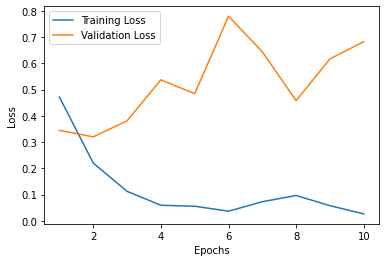

In [24]:
plotLoss(history=history)

In [27]:
saveModel(model)

Saved model to disk


In [28]:
test = loadModel('./main_1_LSTM/Summary','./main_1_LSTM/Weights')

./main_1_LSTM/Summary


C:\Users\User\miniconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\keras\saving\model_config.py:76: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(yaml_string)


In [29]:
result = test.predict(X_test)

In [30]:
showConfusionMatrix(trueLabel=Y_test,resultToShow=result) #LSTM no filter

[[844 144]
 [159 853]]
